This notebook:

1. Loads the labeled patch dataset from `data/processed/patches/patches_labeled.csv`.
2. Splits into train/validation sets.
3. Builds a PyTorch Dataset/DataLoader.
4. Trains a CNN to classify patches as `fruit`, `cut_fruit`, `bomb`.
5. Evaluates and saves the trained model.

In [1]:
import torch

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA available: True
Device name: NVIDIA GeForce RTX 5090


In [2]:
from pathlib import Path
import time

import pandas as pd
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

import numpy as np

import matplotlib.pyplot as plt

# Make sure src/ is importable if you need it later
PROJECT_ROOT = Path("..").resolve()  # notebook in notebooks/
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed" / "patches"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_PROCESSED:", DATA_PROCESSED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

PROJECT_ROOT: C:\Users\azure\Documents\Fruit Ninja Bot
DATA_PROCESSED: C:\Users\azure\Documents\Fruit Ninja Bot\data\processed\patches
Using device: cuda


In [3]:
LABEL_CSV = DATA_PROCESSED / "patches_labeled.csv"
df = pd.read_csv(LABEL_CSV)
print("Total labeled samples:", len(df))
print(df["label"].value_counts())
df.head()

Total labeled samples: 946
label
cut_fruit    438
fruit        291
bomb         217
Name: count, dtype: int64


,patch_filename,label,video_id,frame_idx,center_x_norm,center_y_norm,bbox_x,bbox_y,bbox_w,bbox_h
0,fruitninja1_f000848_o002.png,bomb,fruitninja1,848,0.552344,0.761111,684,528,46,40
1,fruitninja1_f000860_o000.png,bomb,fruitninja1,860,0.528516,0.483333,659,330,35,36
2,fruitninja1_f000872_o002.png,bomb,fruitninja1,872,0.517969,0.320833,644,209,38,44
3,fruitninja1_f000888_o000.png,bomb,fruitninja1,888,0.444531,0.191667,552,117,34,42
4,fruitninja1_f000936_o000.png,bomb,fruitninja1,936,0.354687,0.319444,440,213,28,34


In [4]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label"],
)

print("Train size:", len(train_df))
print("Val size:", len(val_df))

# (optional) Save splits for reproducibility
train_df.to_csv(DATA_PROCESSED / "patches_train.csv", index=False)
val_df.to_csv(DATA_PROCESSED / "patches_val.csv", index=False)

Train size: 756
Val size: 190


In [5]:
# Decide which labels to include
all_labels = sorted(df["label"].unique())
print("All labels:", all_labels)

label_names = all_labels

label_to_idx = {label: i for i, label in enumerate(label_names)}
idx_to_label = {i: label for label, i in label_to_idx.items()}

print("Label to index mapping:", label_to_idx)

# Filter train/val to only those labels
train_df = train_df[train_df["label"].isin(label_names)].reset_index(drop=True)
val_df = val_df[val_df["label"].isin(label_names)].reset_index(drop=True)

print("Filtered train size:", len(train_df))
print("Filtered val size:", len(val_df))
print(train_df["label"].value_counts())


All labels: ['bomb', 'cut_fruit', 'fruit']
Label to index mapping: {'bomb': 0, 'cut_fruit': 1, 'fruit': 2}
Filtered train size: 756
Filtered val size: 190
label
cut_fruit    350
fruit        233
bomb         173
Name: count, dtype: int64


In [6]:
IMG_SIZE = 128
BATCH_SIZE = 128

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # Data augmentation:
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],
    ),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],
    ),
])

In [7]:
class FruitPatchDataset(Dataset):
    def __init__(self, df: pd.DataFrame, root_dir: Path, label_to_idx: dict, transform=None):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.label_to_idx = label_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row["patch_filename"]
        label_str = row["label"]
        label_idx = self.label_to_idx[label_str]

        # Images are stored under root_dir / label / filename
        img_path = self.root_dir / label_str / filename
        img = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        return img, label_idx

In [8]:
train_dataset = FruitPatchDataset(train_df, DATA_PROCESSED, label_to_idx, transform=train_transform)
val_dataset = FruitPatchDataset(val_df, DATA_PROCESSED, label_to_idx, transform=val_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=False,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
)

len(train_dataset), len(val_dataset)

(756, 190)

In [9]:
num_classes = len(label_names)
print("Number of classes:", num_classes)

# Load a pretrained ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# Replace the final fully-connected layer
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model = model.to(device)

Number of classes: 3


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [11]:
def run_epoch(model, dataloader, optimizer, criterion, device, train=True):
    if train:
        model.train()
    else:
        model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            outputs = model(images)
            loss = criterion(outputs, labels)

            if train:
                loss.backward()
                optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [13]:
NUM_EPOCHS = 15
best_val_acc = 0.0
best_model_path = PROJECT_ROOT / "models" / "fruit_classifier_resnet18.pt"
best_model_path.parent.mkdir(parents=True, exist_ok=True)

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = time.time()

    train_loss, train_acc = run_epoch(
        model, train_loader, optimizer, criterion, device, train=True
    )
    val_loss, val_acc = run_epoch(
        model, val_loader, optimizer, criterion, device, train=False
    )

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    elapsed = time.time() - start_time
    print(
        f"Epoch {epoch:02d}/{NUM_EPOCHS} "
        f"- {elapsed:.1f}s "
        f"- train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} "
        f"- val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f}"
    )

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "label_to_idx": label_to_idx,
                "idx_to_label": idx_to_label,
                "img_size": IMG_SIZE,
            },
            best_model_path,
        )
        print(f"  ✔ New best model saved (val_acc={best_val_acc:.3f}) → {best_model_path}")

Epoch 01/15 - 1.7s - train_loss: 0.6136, train_acc: 0.745 - val_loss: 0.2739, val_acc: 0.932
  ✔ New best model saved (val_acc=0.932) → C:\Users\azure\Documents\Fruit Ninja Bot\models\fruit_classifier_resnet18.pt
Epoch 02/15 - 1.2s - train_loss: 0.1734, train_acc: 0.943 - val_loss: 0.1481, val_acc: 0.947
  ✔ New best model saved (val_acc=0.947) → C:\Users\azure\Documents\Fruit Ninja Bot\models\fruit_classifier_resnet18.pt
Epoch 03/15 - 1.2s - train_loss: 0.1006, train_acc: 0.972 - val_loss: 0.1032, val_acc: 0.974
  ✔ New best model saved (val_acc=0.974) → C:\Users\azure\Documents\Fruit Ninja Bot\models\fruit_classifier_resnet18.pt
Epoch 04/15 - 1.2s - train_loss: 0.0828, train_acc: 0.970 - val_loss: 0.0803, val_acc: 0.984
  ✔ New best model saved (val_acc=0.984) → C:\Users\azure\Documents\Fruit Ninja Bot\models\fruit_classifier_resnet18.pt
Epoch 05/15 - 1.2s - train_loss: 0.0462, train_acc: 0.981 - val_loss: 0.0795, val_acc: 0.974
Epoch 06/15 - 1.2s - train_loss: 0.0376, train_acc: 0.9

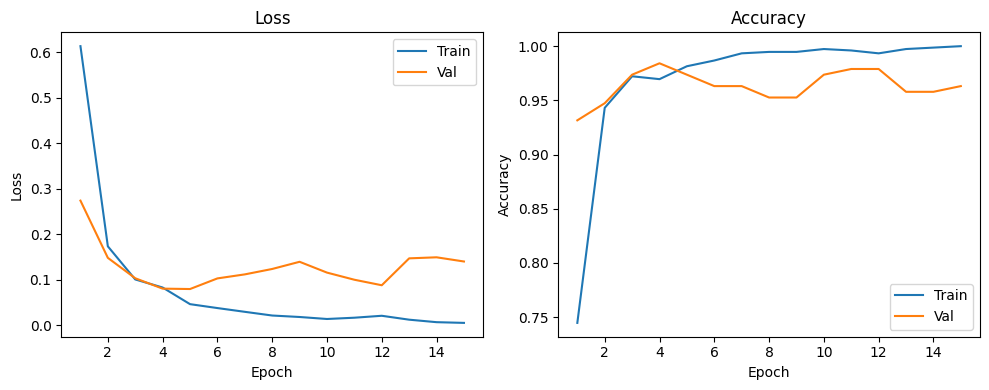

In [14]:
epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train")
plt.plot(epochs, history["val_loss"], label="Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], label="Train")
plt.plot(epochs, history["val_acc"], label="Val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")

plt.tight_layout()
plt.show()

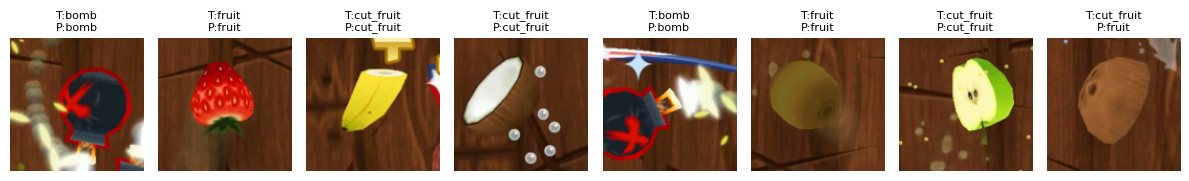

In [15]:
# Load best model weights (if you restarted kernel)
checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

def show_predictions(dataset, n=8):
    idxs = np.random.choice(len(dataset), size=n, replace=False)

    plt.figure(figsize=(12, 3))
    for i, idx in enumerate(idxs):
        img, label_idx = dataset[idx]
        label_str = idx_to_label[label_idx]

        with torch.no_grad():
            logits = model(img.unsqueeze(0).to(device))
            pred_idx = logits.argmax(dim=1).item()
            pred_str = idx_to_label[pred_idx]

        # Undo normalization for display
        img_disp = img.clone()
        img_disp = img_disp * 0.5 + 0.5  # un-normalize
        img_np = img_disp.permute(1, 2, 0).cpu().numpy()

        ax = plt.subplot(1, n, i + 1)
        ax.imshow(img_np)
        ax.axis("off")
        ax.set_title(f"T:{label_str}\nP:{pred_str}", fontsize=8)

    plt.tight_layout()
    plt.show()

show_predictions(val_dataset, n=8)


In [16]:
model.eval()
misclassified = []

with torch.no_grad():
    for idx in range(len(val_dataset)):
        img, true_idx = val_dataset[idx]
        img_input = img.unsqueeze(0).to(device)

        logits = model(img_input)
        pred_idx = logits.argmax(dim=1).item()

        if pred_idx != true_idx:
            misclassified.append((idx, true_idx, pred_idx))

print(f"Total validation samples: {len(val_dataset)}")
print(f"Misclassified samples: {len(misclassified)}")

# Show a quick breakdown by (true, pred) pairs
from collections import Counter
pairs = Counter((ti, pi) for _, ti, pi in misclassified)
print("Confused pairs (true -> pred, counts):")
for (ti, pi), c in pairs.items():
    print(f"  {idx_to_label[ti]} -> {idx_to_label[pi]}: {c}")

Total validation samples: 190
Misclassified samples: 3
Confused pairs (true -> pred, counts):
  cut_fruit -> fruit: 3
